In [229]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [230]:
# read in all the names
words = open('names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [231]:
len(words)

32033

In [232]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))

string_to_integer = {s:i+1 for i,s in enumerate(chars)}
string_to_integer['.'] = 0

integer_to_string = {i:s for s,i in string_to_integer.items()}
print(integer_to_string)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [233]:
# build the dataset
def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?

    X, Y = [], [] # X is the context, Y is the target

    for word in words:
        context = [0] * block_size # start with a context of all '.'
        
        for char in word+'.':
            index = string_to_integer[char]
            X.append(context)
            Y.append(index)
            # print(''.join([integer_to_string[i] for i in context]), '---->', char)
            context = context[1:] + [index]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8) # 80% for training
n2 = int(len(words) * 0.9) # 10% for validation; 10% for testing

X_train, Y_train = build_dataset(words[:n1]) 
X_valid, Y_valid = build_dataset(words[n1:n2]) 
X_test, Y_test = build_dataset(words[n2:]) 


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Build the MLP model

In [234]:
X_train.shape, Y_train.shape # the dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [269]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
w1 = torch.randn((30,200), generator=g)
b1 = torch.randn(200, generator=g)
w2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, w1, b1, w2, b2]

for p in parameters:
    p.requires_grad = True # tell PyTorch to compute gradients for these parameters

In [270]:
sum(p.nelement() for p in parameters)

11897

In [271]:
num_epochs = 100000

learning_rate_exponent = torch.linspace(-3, 0, num_epochs) 
learning_rates = 10 ** learning_rate_exponent # 0.001, 0.0011, 0.0012, ..., 1.0

learning_rate_indeces = []
loss_indeces = []
steps = []

In [272]:


for epoch in range(num_epochs):
    # mini-batch construction
    indices = torch.randint(0, X_train.shape[0], (32,)) # get 32 random indices

    # forward pass
    emb = C[X_train[indices]] # the embedding; (32, 3, 2); get the embeddings for the mini-batch
    h = torch.tanh(emb.view(-1, 30) @ w1 + b1) # the hidden layer; (32, 100)
    logits = h @ w2 + b2 # the logits; (32, 27)
    loss = F.cross_entropy(logits, Y_train[indices]) # the loss of the mini-batch
    
    print(f'{epoch+1} {loss=:.3f}') if (epoch+1) % 10000 == 0 else None

    # backward pass
    for p in parameters:
        p.grad = None # zero the gradients

    loss.backward() # compute the gradients

    # update the parameters
    learning_rate = 0.1 if epoch < (num_epochs/2) else 0.01
    for p in parameters:
        # p.data -= learning_rates[epoch] * p.grad # update the parameters; learning rate decay
        p.data -= p.grad * learning_rate # update the parameters; learning rate decay

    # track stats
    # learning_rate_indeces.append(learning_rate_exponent[epoch])
    steps.append(epoch)
    loss_indeces.append(loss.log10().item())


10000 loss=2.763
20000 loss=2.789
30000 loss=1.960
40000 loss=2.717
50000 loss=2.568
60000 loss=2.247
70000 loss=1.970
80000 loss=2.172
90000 loss=1.892
100000 loss=1.958


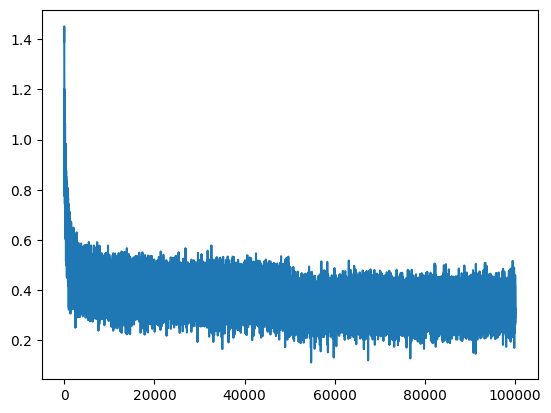

In [273]:
plt.plot(steps, loss_indeces)

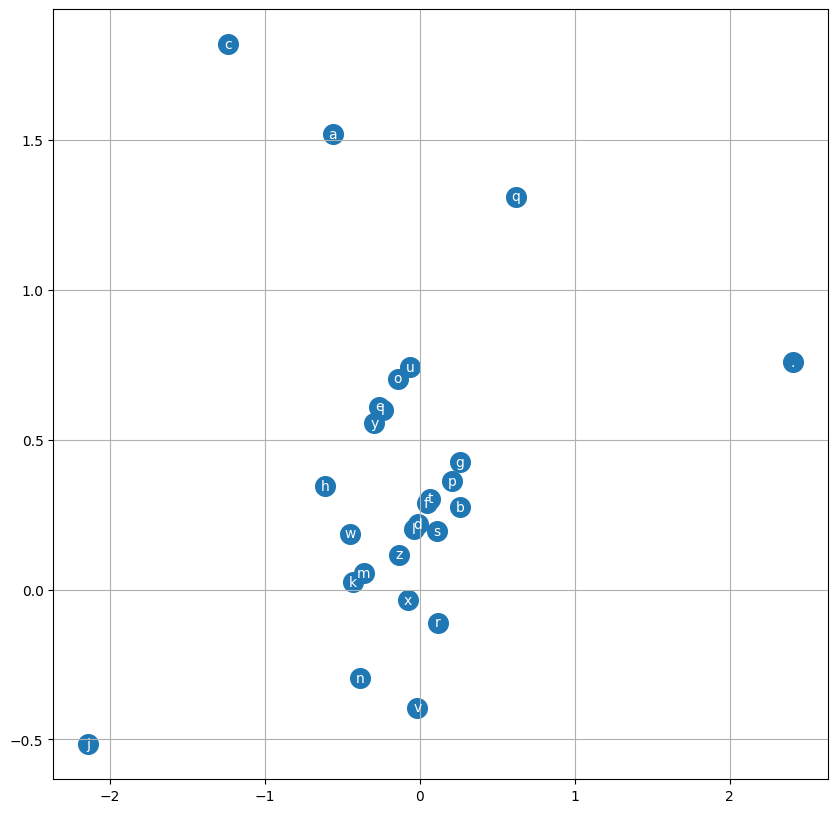

In [274]:
plt.figure(figsize=(10, 10))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), integer_to_string[i], ha='center', va='center', color='white')

plt.grid('minor')

In [275]:
# evaluate the loss on the whole training dataset
emb = C[X_train] # the embedding; (N, 3, 2); get the embeddings for the whole dataset
h = torch.tanh(emb.view(-1, 30) @ w1 + b1) # the hidden layer; (N, 100)
logits = h @ w2 + b2 # the logits; (N, 27)
loss = F.cross_entropy(logits, Y_train) # the loss of the whole dataset
print(f'{loss=:.3f}')


loss=2.202


In [276]:
# evaluate the loss on the whole validation dataset
emb = C[X_valid] # the embedding; (N, 3, 2); get the embeddings for the whole dataset
h = torch.tanh(emb.view(-1, 30) @ w1 + b1) # the hidden layer; (N, 100)
logits = h @ w2 + b2 # the logits; (N, 27)
loss = F.cross_entropy(logits, Y_valid) # the loss of the whole dataset
print(f'{loss=:.3f}')


loss=2.221


In [280]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size = 3 # context length: how many characters do we take to predict the next one?

for _ in range(20):
    output = []

    context = [0] * block_size # initialize with '...'

    while True:
        embedding = C[torch.tensor(context)]
        h = torch.tanh(embedding.view(1, -1) @ w1 + b1)
        logits = h @ w2 + b2
        probabilities = F.softmax(logits, dim=1)
        index = torch.multinomial(probabilities, 1, generator=g).item()
        context = context[1:] + [index]
        output.append(index)
        if index == 0:
            break

    print(''.join([integer_to_string[i] for i in output]))


carmah.
amille.
khy.
mili.
taty.
hacarsie.
mahnen.
deliah.
jareei.
nermara.
chaiiv.
kaleig.
halma.
kin.
quinn.
sulin.
alia.
biur.
jerm.
dearyni.
